In [86]:
# General libraries
import numpy as np
import pandas as pd
from skimpy import skim
import itertools
from scipy.stats import zscore

# Visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

# Date libraries
from datetime import datetime, timedelta, date
import time
import holidays

# Prophet library
from prophet import Prophet 
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import cross_validation

from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams

from statsmodels.tsa.stattools import adfuller

import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose

In [87]:
# Import Data
df = pd.read_excel("db_(2022-oct_2024).xlsx")

# Today 
today = datetime.today()

df['DAY_DT'] = pd.to_datetime(df['DAY_DT'])

# Filter data until today
df = df.loc[df['DAY_DT'] < today]

df

,REGION,ABB_REGION,SUB_REGION,CLUSTER,FSC_YEAR,FSC_MONTH_NUM,FSC_WEEK_NUM,FSC_WEEK_DAY_NUM,DAY_DT,RPL_Units,RPR_Units
0,1-Atlantic,NB,NB,Cluster Fredericton,2022,1,1,3,2022-01-03,5.0,4.0
1,1-Atlantic,NB,NB,Cluster Fredericton,2022,1,1,4,2022-01-04,10.0,4.0
2,1-Atlantic,NB,NB,Cluster Fredericton,2022,1,1,5,2022-01-05,13.0,5.0
3,1-Atlantic,NB,NB,Cluster Fredericton,2022,1,1,6,2022-01-06,12.0,8.0
4,1-Atlantic,NB,NB,Cluster Fredericton,2022,1,1,7,2022-01-07,9.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...
48425,7-BC,BC,GVA WEST & ISLAND,Cluster Vanc-Kingsway,2024,10,41,6,2024-10-10,NaN,NaN
48426,7-BC,BC,GVA WEST & ISLAND,Cluster Vanc-Kingsway,2024,10,41,7,2024-10-11,NaN,NaN
48427,7-BC,BC,GVA WEST & ISLAND,Cluster Vanc-Kingsway,2024,10,42,3,2024-10-14,NaN,NaN
48428,7-BC,BC,GVA WEST & ISLAND,Cluster Vanc-Kingsway,2024,10,42,4,2024-10-15,NaN,NaN


In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45136 entries, 0 to 48429
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   REGION            45136 non-null  object        
 1   ABB_REGION        31304 non-null  object        
 2   SUB_REGION        45136 non-null  object        
 3   CLUSTER           45136 non-null  object        
 4   FSC_YEAR          45136 non-null  int64         
 5   FSC_MONTH_NUM     45136 non-null  int64         
 6   FSC_WEEK_NUM      45136 non-null  int64         
 7   FSC_WEEK_DAY_NUM  45136 non-null  int64         
 8   DAY_DT            45136 non-null  datetime64[ns]
 9   RPL_Units         41304 non-null  float64       
 10  RPR_Units         40595 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(4), object(4)
memory usage: 4.1+ MB


In [89]:
skim(df)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 45136  │ │ string      │ 4     │                                                          │
│ │ Number of columns │ 11     │ │ int32       │ 4     │                                                          │
│ └───────────────────┴────────┘ │ float64     │ 2     │                                                          │
│                                │ datetime64  │ 1     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━━┓  │
│ ┃ column_name           ┃ NA     ┃ NA %    ┃ mean   ┃ sd   ┃ p0    ┃ p25   ┃ p50   ┃ p75   ┃ p100  ┃ hist    ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━━┩  │
│ │ FSC_YEAR              │      0 │       0 │   2000 │  0.8 │  2000 │  2000 │  2000 │  2000 │  2000 │ ▇  ▇ ▆  │  │
│ │ FSC_MONTH_NUM         │      0 │       0 │    6.1 │  3.3 │     1 │     3 │     6 │     9 │    12 │ ▇▇▇▇▇▅  │  │
│ │ FSC_WEEK_NUM          │      0 │       0 │     25 │   14 │     1 │    13 │    25 │    37 │    52 │ ▇▇▇▇▇▅  │  │
│ │ FSC_WEEK_DAY_NUM      │      0 │       0 │      5 │  1.4 │     3 │     4 │     5 │     6 │     7 │ ▇▇ ▇▇▇  │  │
│ │ RPL_Units             │   3832 │    8.49 │     16 │   10 │    -1 │     8 │    13 │    21 │   100 │   ▇▅▁   │  │
│ │ RPR_Units             │   4541 │   10.06 │    8.8 │  5.7 │    -2 │     4 │     8 │    12 │    44 │  ▆▇▃▁   │  │
│ └───────────────────────┴────────┴─────────┴────────┴──────┴───────┴───────┴───────┴───────┴───────┴─────────┘  │
│                                                    datetime                                                     │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name            ┃ NA     ┃ NA %      ┃ first               ┃ last                ┃ frequency        ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩  │
│ │ DAY_DT                 │      0 │         0 │     2022-01-03      │     2024-10-16      │ None             │  │
│ └────────────────────────┴────────┴───────────┴─────────────────────┴─────────────────────┴──────────────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name             ┃ NA           ┃ NA %        ┃ words per row              ┃ total words            ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ REGION                  │            0 │           0 │                          1 │                  45136 │  │
│ │ ABB_REGION              │        13832 │       30.65 │                       0.69 │                  31304 │  │
│ │ SUB_REGION              │            0 │           0 │                        2.2 │                  99008 │  │
│ │ CLUSTER                 │            0 │           0

## EXPLORING DATA

In [93]:
# Checking for missing data
print(df.isnull().sum())

# Check unique values in categorical columns
print(df['REGION'].unique())
print(df['SUB_REGION'].unique())
print(df['CLUSTER'].unique())


REGION                  0
ABB_REGION          13832
SUB_REGION              0
CLUSTER                 0
FSC_YEAR                0
FSC_MONTH_NUM           0
FSC_WEEK_NUM            0
FSC_WEEK_DAY_NUM        0
DAY_DT                  0
RPL_Units               0
RPR_Units               0
dtype: int64
['1-Atlantic' '2-Quebec' '3-Ontario' '4-Manitoba' '5-Saskatchewan'
 '6-Alberta' '7-BC']
['NB' 'NF' 'NS' 'PEI' 'MONT & CENTER' 'MTL & NORTH-WEST'
 'MTL NORTH SHORE & MAURICIE' 'MTL SOUTH SHORE' 'QC & NORTH-EAST'
 'GTA EAST' 'GTA WEST' 'ON EAST' 'ON NORTH' 'ON WEST' 'MB' 'SK' 'AB'
 'BC CENTRAL' 'GVA EAST' 'GVA WEST & ISLAND']
['Cluster Fredericton' 'Cluster Moncton' 'Cluster St-John'
 'Indies N-Brunswick' 'Cluster St-Johns' 'Indies N-Foundland'
 'Cluster Halifax' 'Indies N-Scotia' 'Cluster Charlottetown' 'Indies PEI'
 'Cluster Beloeil-St.B-Ch' 'Cluster Sherbrooke' 'Cluster St.J-Varennes'
 'Indies QC-CTR' 'Cluster Lachine-Lasalle' 'Cluster MTL-East'
 'Cluster PC-CV' 'Cluster Rep-LG' 'Indies QC-N

In [92]:
# Fill missing values (mostly weekends with 0 sales)
df['RPL_Units'] = df['RPL_Units'].fillna(0)
df['RPR_Units'] = df['RPR_Units'].fillna(0)

In [95]:
# Aggregating sales by Fiscal Year and Month using a list for column selection
monthly_sales_fiscal = df.groupby(['FSC_YEAR', 'FSC_MONTH_NUM'])[['RPL_Units', 'RPR_Units']].sum().reset_index()

# Sorting by year and month for proper visualization
monthly_sales_fiscal = monthly_sales_fiscal.sort_values(by=['FSC_YEAR', 'FSC_MONTH_NUM'])

In [96]:
# Aggregating sales by Fiscal Year and Week using a list for column selection
weekly_sales_fiscal = df.groupby(['FSC_YEAR', 'FSC_WEEK_NUM'])[['RPL_Units', 'RPR_Units']].sum().reset_index()

# Sorting by year and week for proper visualization
weekly_sales_fiscal = weekly_sales_fiscal.sort_values(by=['FSC_YEAR', 'FSC_WEEK_NUM'])

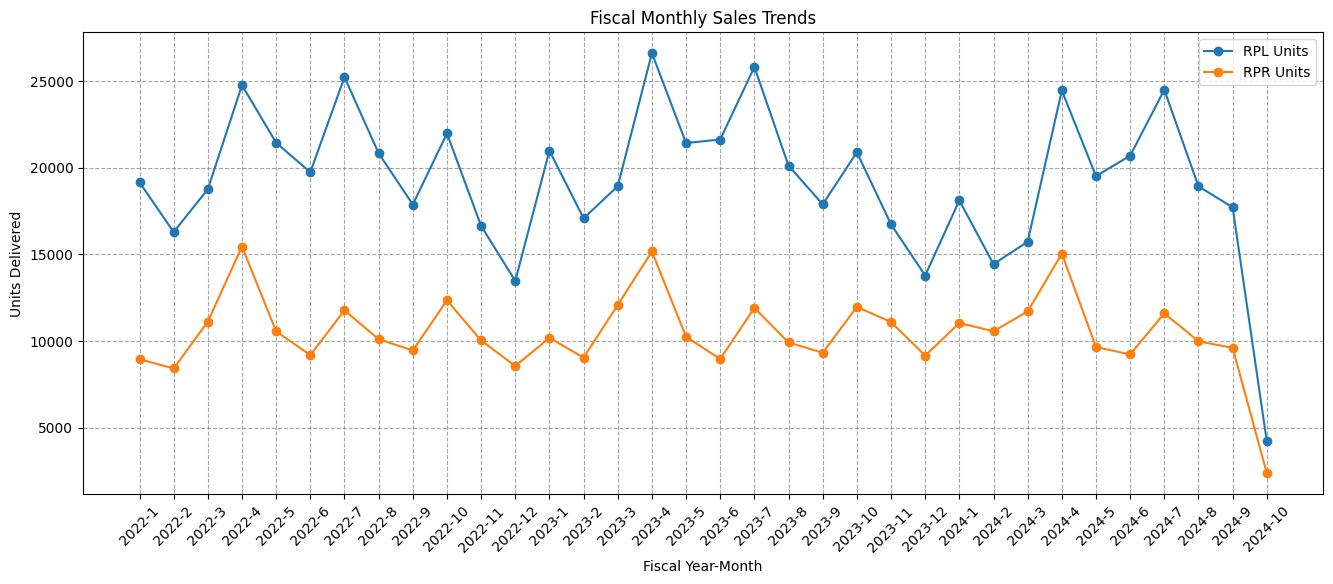

In [109]:
# Plot Fiscal Month sales
plt.figure(figsize=(16, 6))
plt.plot(monthly_sales_fiscal['FSC_YEAR'].astype(str) + '-' + monthly_sales_fiscal['FSC_MONTH_NUM'].astype(str),
         monthly_sales_fiscal['RPL_Units'], label='RPL Units', marker='o')
plt.plot(monthly_sales_fiscal['FSC_YEAR'].astype(str) + '-' + monthly_sales_fiscal['FSC_MONTH_NUM'].astype(str),
         monthly_sales_fiscal['RPR_Units'], label='RPR Units', marker='o')
plt.xlabel('Fiscal Year-Month')
plt.ylabel('Units Delivered')
plt.title('Fiscal Monthly Sales Trends')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', color='gray', alpha=0.7)
plt.legend()
plt.show()


In [111]:
# Pivoting data to compare fiscal monthly trends by year
pivot_rpl = monthly_sales_fiscal.pivot(index='FSC_MONTH_NUM', columns='FSC_YEAR', values='RPL_Units')

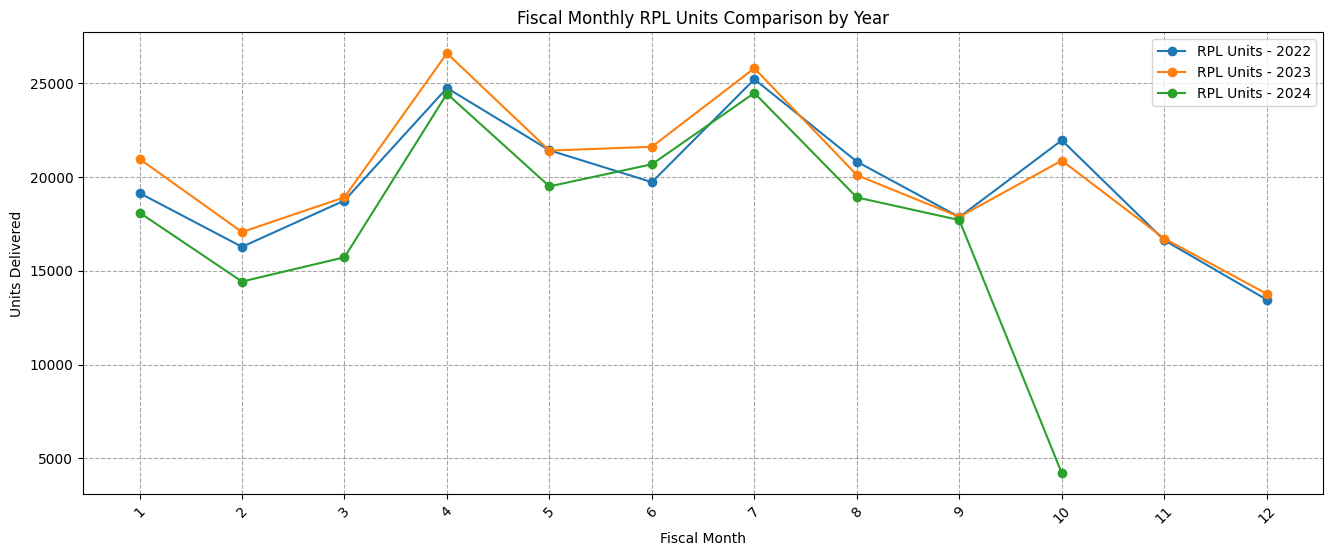

In [113]:
plt.figure(figsize=(16, 6))

# Plot each year as a separate line
for year in pivot_rpl.columns:
    plt.plot(pivot_rpl.index, pivot_rpl[year], label=f'RPL Units - {year}', marker='o')

plt.xlabel('Fiscal Month')
plt.ylabel('Units Delivered')
plt.title('Fiscal Monthly RPL Units Comparison by Year')
plt.xticks(ticks=pivot_rpl.index, labels=pivot_rpl.index, rotation=45)
plt.grid(True, linestyle='--', color='gray', alpha=0.7)
plt.legend()
plt.show()

<Figure size 1200x600 with 0 Axes>

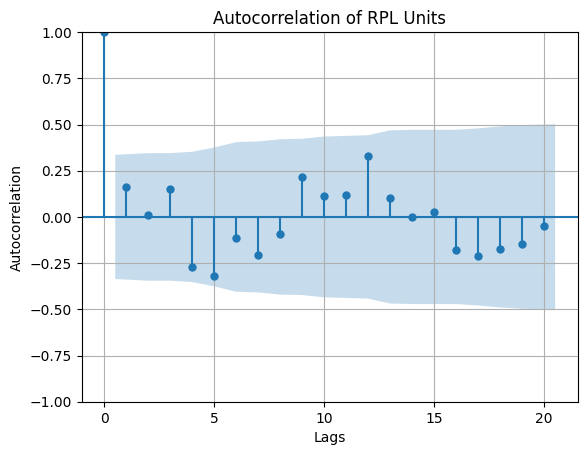

In [118]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Set the index to be the fiscal month for ACF analysis
monthly_sales_fiscal['Fiscal_Month'] = monthly_sales_fiscal['FSC_YEAR'].astype(str) + '-' + monthly_sales_fiscal['FSC_MONTH_NUM'].astype(str)
monthly_sales_fiscal.set_index('Fiscal_Month', inplace=True)

# Plot ACF for RPL_Units
plt.figure(figsize=(12, 6))
plot_acf(monthly_sales_fiscal['RPL_Units'], lags=20)  # Adjust lags as needed
plt.title('Autocorrelation of RPL Units')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

<Figure size 1200x600 with 0 Axes>

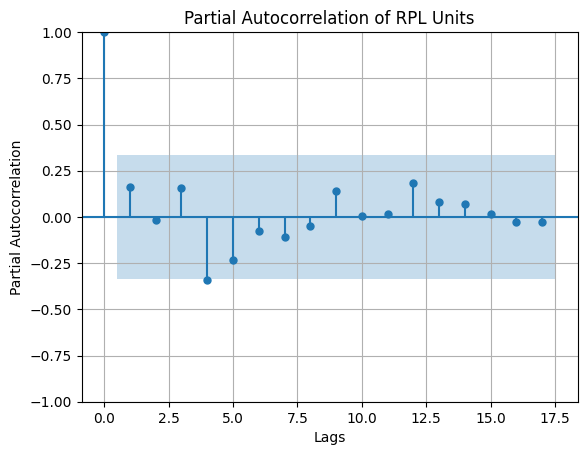

In [122]:
monthly_sales_fiscal['Fiscal_Month'] = monthly_sales_fiscal['FSC_YEAR'].astype(str) + '-' + monthly_sales_fiscal['FSC_MONTH_NUM'].astype(str)
monthly_sales_fiscal.set_index('Fiscal_Month', inplace=True)

# Plot PACF for RPL_Units
plt.figure(figsize=(12, 6))
plot_pacf(monthly_sales_fiscal['RPL_Units'], lags=17)  # Adjust lags as needed
plt.title('Partial Autocorrelation of RPL Units')
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.grid(True)
plt.show()

## IMPORT HOLIDAY DATA

In [69]:
# Importing holiday data
holiday = pd.DataFrame([])
canada_holidays = holidays.CA() #dictionary of canadian holidays

for sub in ['AB', 'BC', 'MB', 'NB', 'NL', 'NS', 'ON', 'PE', 'QC', 'SK']: #List based on Holidays documentation
    for date_, name in sorted(holidays.CA(years=[2022, 2023, 2024], subdiv=sub).items()):
        holiday = pd.concat([holiday, pd.DataFrame({'ds': date_, 'province': sub, 'lower_window': -2, 'upper_window': 1}, index=[0])], ignore_index=True)

#Convert 'ds' column to datetime format in holiday DataFrame
holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d')

#Replace 'NL' to 'NF' to match my data
holiday['province'] = holiday['province'].replace('NL', 'NF')

#Adjust 'ds' to the previous Monday
holiday['ds'] = holiday['ds'] - pd.to_timedelta(holiday['ds'].dt.weekday, unit='D')

df_holiday = holiday.copy()

holiday

,ds,province,lower_window,upper_window
0,2021-12-27,AB,-2,1
1,2022-01-03,AB,-2,1
2,2022-02-21,AB,-2,1
3,2022-04-11,AB,-2,1
4,2022-05-23,AB,-2,1
...,...,...,...,...
288,2024-08-05,SK,-2,1
289,2024-09-02,SK,-2,1
290,2024-10-14,SK,-2,1
291,2024-11-11,SK,-2,1


In [70]:
holiday['province'].value_counts()

province
BC    36
SK    35
AB    31
PE    30
ON    29
NB    28
MB    27
QC    27
NS    26
NF    24
Name: count, dtype: int64

## PLOT SEASONALITY

In [71]:
# Group data for all canada for this exercise
df = df.groupby('DAY_DT')['RPL_Units'].sum().reset_index()

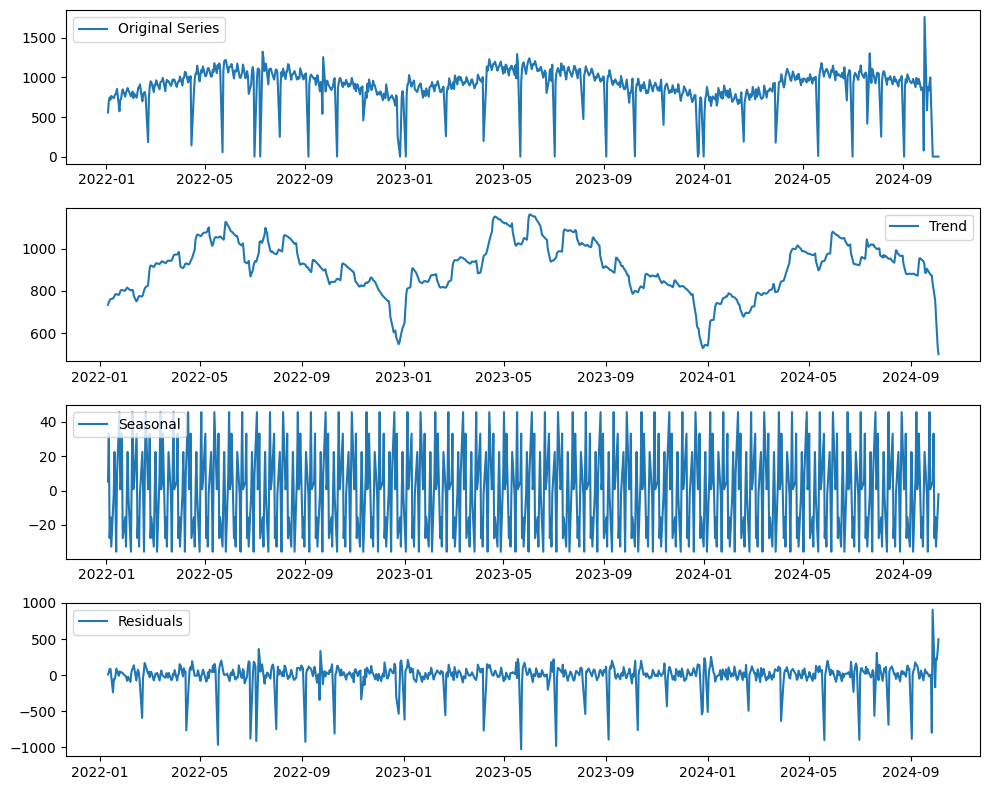

In [72]:
df = df.set_index(['DAY_DT'])

df['RPL_Units'] = df['RPL_Units'].fillna(0)

result = seasonal_decompose(df['RPL_Units'], model='additive', period=12)
trend = result.trend.dropna()
seasonal = result.seasonal.dropna()
residual = result.resid.dropna()

# Plot the decomposed components
plt.figure(figsize=(10, 8))

plt.subplot(4, 1, 1)
plt.plot(df['RPL_Units'], label='Original Series')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(trend, label='Trend')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(seasonal, label='Seasonal')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(residual, label='Residuals')
plt.legend()

plt.tight_layout()
plt.show()

C:\Users\ggarcia\AppData\Local\Temp\ipykernel_21716\2643261911.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Quarter'] = df_filtered.index.to_period('Q')
C:\Users\ggarcia\AppData\Local\Temp\ipykernel_21716\2643261911.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Month'] = df_filtered.index.month
C:\Users\ggarcia\AppData\Local\Temp\ipykernel_21716\2643261911.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

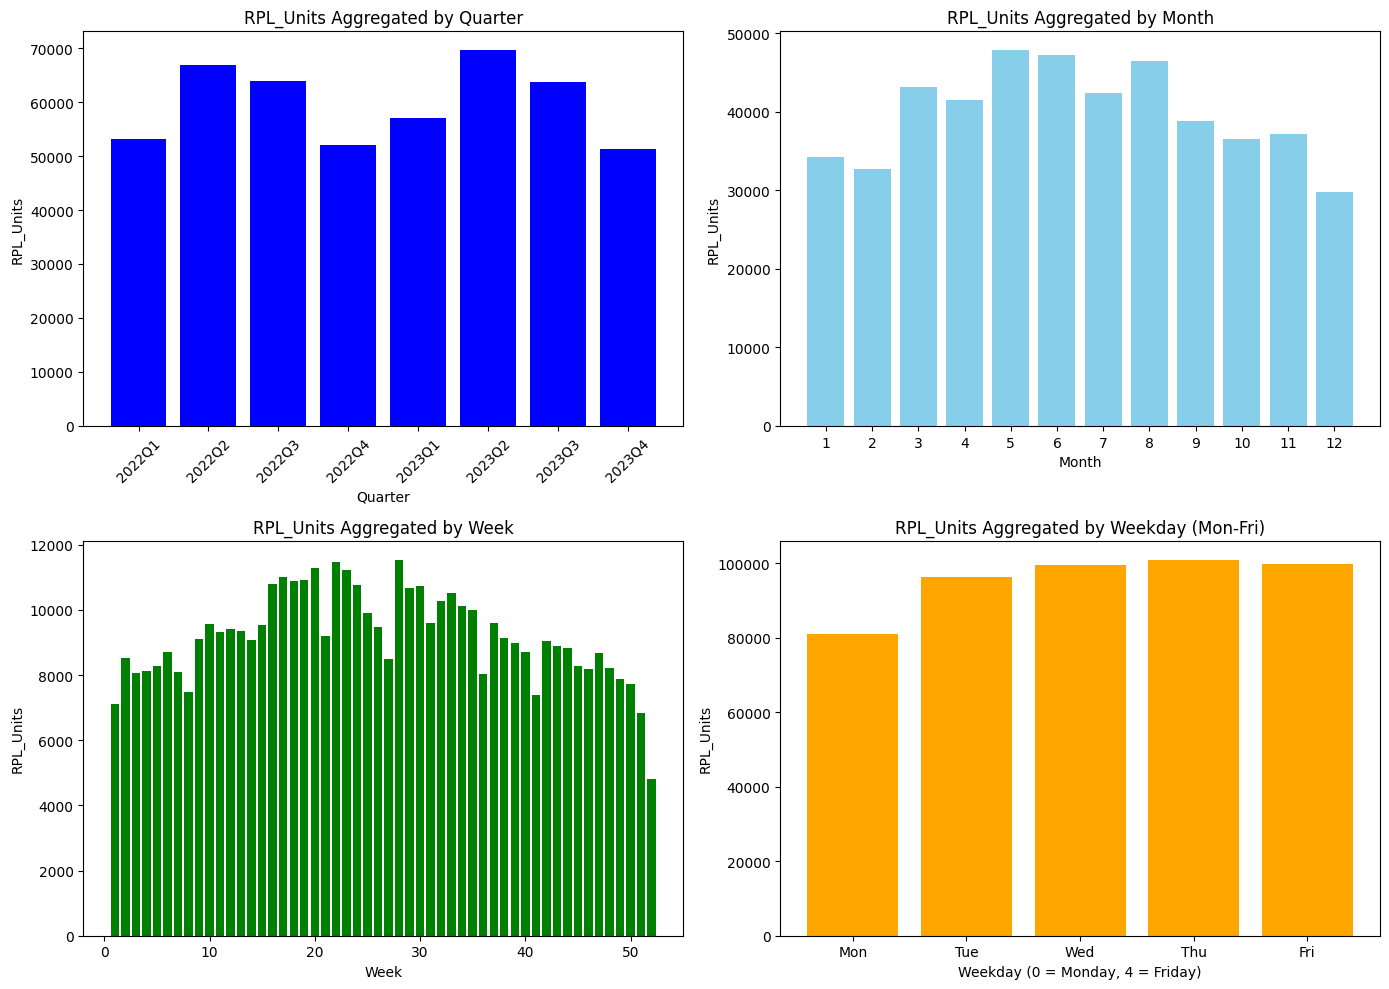

In [81]:
# Ensure the index is in datetime format
df.index = pd.to_datetime(df.index)

# Filter the period from 2022-01 to 2024-01
df_filtered = df[(df.index >= '2022-01-01') & (df.index < '2024-01-01')]

# Add columns for seasonality based on the index (dates)
df_filtered['Quarter'] = df_filtered.index.to_period('Q')
df_filtered['Month'] = df_filtered.index.month
df_filtered['Week'] = df_filtered.index.isocalendar().week
df_filtered['Weekday'] = df_filtered.index.weekday

# Grouping
df_quarter = df_filtered.groupby('Quarter')['RPL_Units'].sum().reset_index()
df_month = df_filtered.groupby('Month')['RPL_Units'].sum().reset_index()
df_week = df_filtered.groupby('Week')['RPL_Units'].sum().reset_index()
df_weekday = df_filtered.groupby('Weekday')['RPL_Units'].sum().reset_index()

# Plot settings
plt.figure(figsize=(14, 10))

# 1. Plotting by Quarter
plt.subplot(2, 2, 1)
plt.bar(df_quarter['Quarter'].astype(str), df_quarter['RPL_Units'], color='blue')
plt.title('RPL_Units Aggregated by Quarter')
plt.xlabel('Quarter')
plt.ylabel('RPL_Units')
plt.xticks(rotation=45)
plt.grid(False)

# 2. Plotting by Month
plt.subplot(2, 2, 2)
plt.bar(df_month['Month'], df_month['RPL_Units'], color='skyblue')
plt.title('RPL_Units Aggregated by Month')
plt.xlabel('Month')
plt.ylabel('RPL_Units')
plt.grid(False)
plt.xticks(df_month['Month'])

# 3. Plotting by Week
plt.subplot(2, 2, 3)
plt.bar(df_week['Week'], df_week['RPL_Units'], color='green')
plt.title('RPL_Units Aggregated by Week')
plt.xlabel('Week')
plt.ylabel('RPL_Units')
plt.grid(False)

# 4. Plotting by Weekday (excluding weekends)
plt.subplot(2, 2, 4)
plt.bar(df_weekday['Weekday'], df_weekday['RPL_Units'], color='orange')
plt.title('RPL_Units Aggregated by Weekday (Mon-Fri)')
plt.xlabel('Weekday (0 = Monday, 4 = Friday)')
plt.ylabel('RPL_Units')
plt.grid(False)
plt.xticks(df_weekday['Weekday'], ['Mon', 'Tue', 'Wed', 'Thu', 'Fri'])

# Adjust layout and display all plots
plt.tight_layout()
plt.show()

## SARIMAX